# Training on AssociateTracks8.csv Data

In [1]:
# DGCNN v 0.4.0
# Last edit: 22/02/2022


In [2]:
# pip install matplotlib==3.3.4 -> Optional

In [3]:
import os
import sys
import glob
import h5py
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [4]:
import DGCNN_toolkit as nn
import analysis_toolkit as atk

In [5]:
df = pd.read_csv("AssociateTracks8.csv")
df.head()

,iEvent,iHit,planeRec,wireRec,HitRecTime0,HitRecTime1,Charge0,Charge1,x,y,z,dchMCHitId,idxTrk,parent,track,particle
0,0,0,1,297,-2.265900e-07,-2.287020e-07,2.456280e-10,3.381540e-10,-23.9023,1.882950,47.445000,43.0,5.0,-1.0,1,2.0
1,0,1,1,298,-3.645500e-07,-3.665130e-07,5.616130e-10,6.533530e-10,-23.2507,-0.745385,22.603200,44.0,5.0,-1.0,1,2.0
2,0,2,1,313,-2.922580e-07,-2.916970e-07,1.225900e-09,4.086350e-10,-28.4720,-12.436400,-149.675000,NaN,NaN,NaN,3,NaN
3,0,3,1,313,-2.530840e-07,-2.535690e-07,8.378640e-10,8.398460e-10,-21.8402,7.366170,0.353747,25.0,5.0,-1.0,1,2.0
4,0,4,1,314,-3.646010e-07,-3.651530e-07,6.277870e-10,6.410150e-10,-21.4532,8.437870,3.120980,26.0,5.0,-1.0,1,2.0


Rows with NaN are due to noise hits

There are 70k events, but 100k was generated. \
Some of them are not here, because if no hits are detected in the detector, they were not written to the csv file.
&nbsp;

In [6]:
df[df.iEvent == 5].head()

,iEvent,iHit,planeRec,wireRec,HitRecTime0,HitRecTime1,Charge0,Charge1,x,y,z,dchMCHitId,idxTrk,parent,track,particle
59,5,0,1,202,-3.811770e-07,-3.806270e-07,4.042820e-10,3.634120e-10,22.35520,6.03474,-15.93640,15.0,0.0,-1.0,2,3.0
60,5,1,1,203,-1.919240e-07,-1.912570e-07,5.294380e-10,4.785150e-10,22.55590,5.18795,-15.12360,14.0,0.0,-1.0,2,3.0
61,5,2,1,231,-2.522800e-07,-2.519160e-07,5.411510e-10,5.277170e-10,16.73340,-15.85940,-3.76244,13.0,0.0,-1.0,2,3.0
62,5,3,1,232,-3.849620e-07,-3.847320e-07,3.981010e-10,3.669230e-10,17.05940,-15.59200,-12.20000,NaN,NaN,NaN,3,NaN
63,5,4,1,245,-2.000500e-07,-1.987600e-07,1.813670e-10,2.038980e-10,5.19372,-22.58790,17.50650,41.0,0.0,-1.0,2,3.0


In [7]:
# Trigger Condition
# Trigger is applied just to make the plot more appealing
# We don't lose many hits
trig_df = df[(df["HitRecTime0"]<0) & (df["HitRecTime0"]>-7e-7)]
trig_df.shape

del df

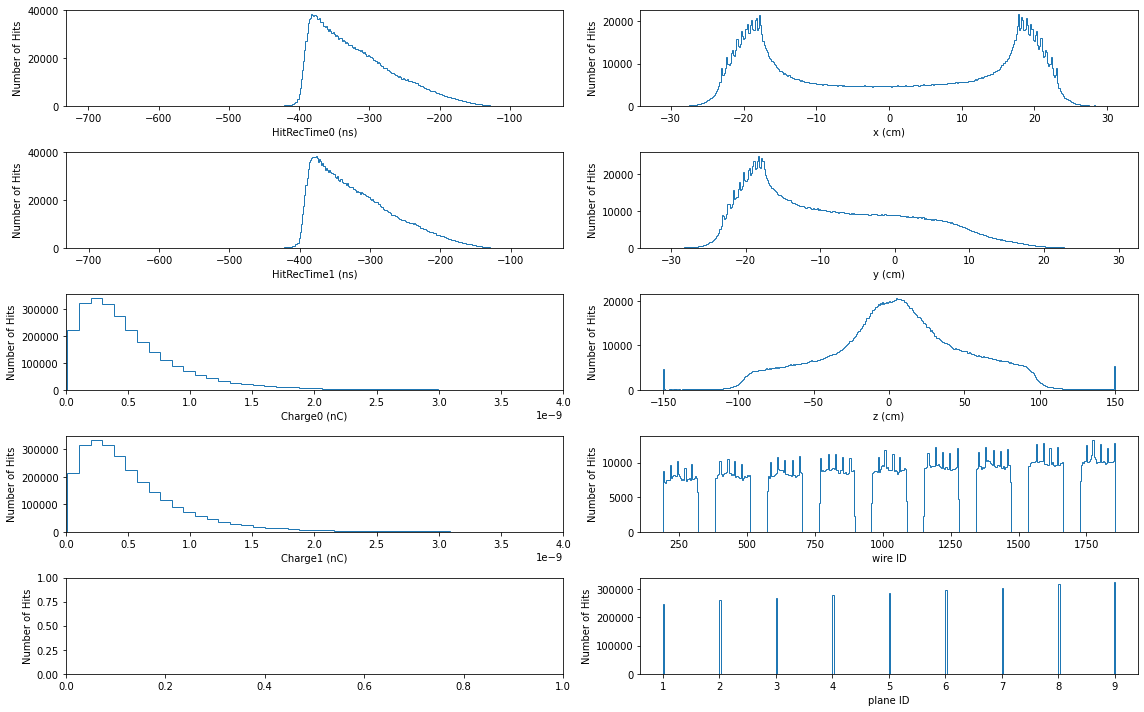

In [8]:
atk.sup_plot(trig_df,400, 4*10**-9)

In [9]:
# The dataframe must be split into data and labels

data, label = nn.prepare_input(trig_df, "MC")

In [10]:
# Separate test and training set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, label, test_size=0.20, random_state=42)

In [11]:
### Uncomment if you don't have enough memory #####
#
del data, label
#
### Uncomment if you don't have enough memory #####

In [12]:
# Create Dataset objects to be fed into neural network.

num_hits = 432
num_classes = 5
train = nn.Dataset(X_train, y_train, num_classes, num_clouds=None)
test = nn.Dataset(X_test, y_test, num_classes, num_clouds=None)

In [13]:
# Show the related shapes

print(train['points'].shape)
print(test['points'].shape)
print(train['features'].shape)
print(test['features'].shape)
print(train['mask'].shape)
print(test['mask'].shape)

(56765, 432, 3)
(14192, 432, 3)
(56765, 432, 3)
(14192, 432, 3)
(56765, 432, 1)
(14192, 432, 1)


In [14]:
# Show the related shapes

input_shapes = {k:train[k].shape[1:] for k in train.X}
print(input_shapes)
model = nn.get_DGCNN(num_classes, input_shapes)

{'points': (432, 3), 'features': (432, 3), 'mask': (432, 1)}


In [15]:
# Compile the model and diplay its summary

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=nn.lr_schedule(0)),
              metrics=[nn.phys_accuracy_onnx])
model.summary()

Model: "DGCNN_SG"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 432, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, 432, 1)]     0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 432, 1)]     0           tf_op_layer_NotEqual[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp [(None, 432, 1)]     0           tf_op_layer_Cast[0][0]           
___________________________________________________________________________________________

In [16]:
# Prepare model model saving directory.

import os
save_dir = 'model_checkpoints'
# _wn: with noise
# _onnx: onnx compatible (1D output)

model_name = 'DGCNN_modelbest_wn_onnx.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)


# Prepare callbacks for model saving and for learning rate adjustment.

checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_phys_accuracy_onnx',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(nn.lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler]

In [17]:
# Training parameters

batch_size = 32
epochs = 50

In [18]:
# Unless you want to train, type no.

x = input("Type 'new train' if you really want to continue.")
x
# x = "new train"

Type 'new train' if you really want to continue. no


'no'

In [19]:
if x == "new train":
    import datetime
    
    train.shuffle()
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


    history = model.fit(train.X, train.y.reshape(train.y.shape[0], -1),
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(test.X, test.y.reshape(test.y.shape[0], -1)),
              shuffle=True,
              callbacks=[checkpoint, lr_scheduler])

else:
    model.load_weights("model_checkpoints/DGCNN_modelbest_wn_onnx.h5")

In [20]:
if x == "new train":
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
    plt.savefig("training_plot.png")
    plt.show()

In [21]:
# Predict, and reshape the output.

pred = model.predict(test.X)
pred = pred.reshape([-1,num_hits,num_classes])

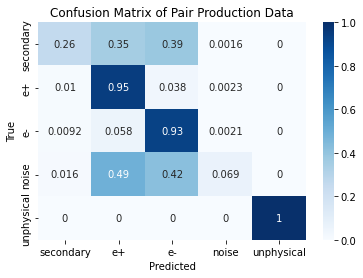

In [22]:
atk.get_confusion_matrix(test, pred,
                     normalize='true', log=False, save=True)

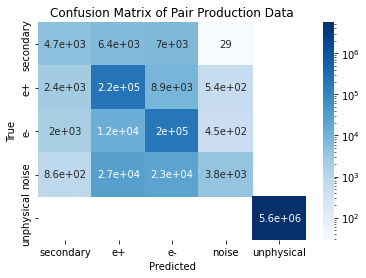

In [23]:
atk.get_confusion_matrix(test, pred, log=True, save=True)

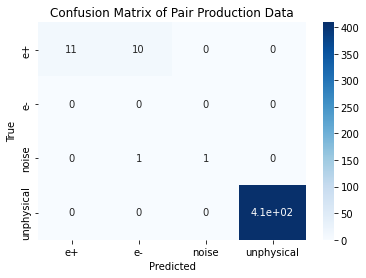

In [24]:
# Getting a confusion matrix for a single event.

atk.get_confusion_matrix(test.y[1], pred[1])

In [25]:
# Checking if our confusion matrix works exactly like the sklearn confusion matrix.

from sklearn.metrics import confusion_matrix
confusion_matrix(test.y[1].argmax(-1), pred[1].argmax(-1))

array([[ 11,  10,   0,   0],
       [  0,   0,   0,   0],
       [  0,   1,   1,   0],
       [  0,   0,   0, 409]])

## 
## Selecting an event and displaying it

In [26]:
# Selecting an event

atk.EventSelector(trig_df, 9).sub_df

,iEvent,iHit,planeRec,wireRec,HitRecTime0,HitRecTime1,Charge0,Charge1,x,y,z,dchMCHitId,idxTrk,parent,track,particle
218,9,0,1,307,-3.438250e-07,-3.374240e-07,8.791240e-11,4.485970e-11,-24.5726,-10.48800,-97.0672,10.0,0.0,-1.0,2,3.0
219,9,1,1,308,-2.676940e-07,-2.612890e-07,9.230640e-10,4.733260e-10,-24.8881,-9.58842,-96.4122,9.0,0.0,-1.0,2,3.0
220,9,2,2,499,-3.151990e-07,-3.118670e-07,8.384720e-10,6.160160e-10,-21.4197,8.76699,-45.8028,NaN,NaN,NaN,3,NaN
221,9,3,2,500,-3.909870e-07,-3.878890e-07,4.006080e-10,2.892600e-10,-21.0699,9.80057,-48.3366,7.0,0.0,-1.0,2,3.0
222,9,4,2,501,-2.482610e-07,-2.451310e-07,5.948990e-10,4.356200e-10,-20.7885,10.21320,-46.2869,6.0,0.0,-1.0,2,3.0
223,9,5,4,887,-3.180620e-07,-3.151630e-07,2.220990e-09,1.615930e-09,-18.7737,10.93810,-47.2600,5.0,0.0,-1.0,2,3.0
224,9,6,4,888,-3.583220e-07,-3.551750e-07,8.116470e-10,5.452440e-10,-17.9988,12.94990,-58.8403,4.0,0.0,-1.0,2,3.0
225,9,7,6,1274,-2.905450e-07,-2.878770e-07,1.985240e-09,1.513250e-09,-16.7692,11.16370,-40.4597,3.0,0.0,-1.0,2,3.0
226,9,8,6,1275,-3.927850e-07,-3.901310e-07,3.498090e-10,2.693130e-10,-16.4594,11.54520,-38.9909,NaN,NaN,NaN,3,NaN
227,9,9,8,1661,-3.365050e-07,-3.341670e-07,5.461920e-10,4.352190e-10,-14.9179,11.29340,-33.9298,1.0,0.0,-1.0,2,3.0


In [27]:
# testpred contas the predicted label, not the true label.

testpred = atk.combine_testpred(test,pred)
testpred

,iEvent,iHit,x,y,z,track
0,0,0,-20.7778,10.53850,24.3877,1
1,0,1,-18.0667,17.54850,72.9478,1
2,0,2,-19.9314,9.08452,28.4150,1
3,0,3,-19.6259,9.72355,28.3490,1
4,0,4,-19.3891,5.91772,11.8168,1
...,...,...,...,...,...,...
6130939,14191,427,0.0000,0.00000,0.0000,4
6130940,14191,428,0.0000,0.00000,0.0000,4
6130941,14191,429,0.0000,0.00000,0.0000,4
6130942,14191,430,0.0000,0.00000,0.0000,4


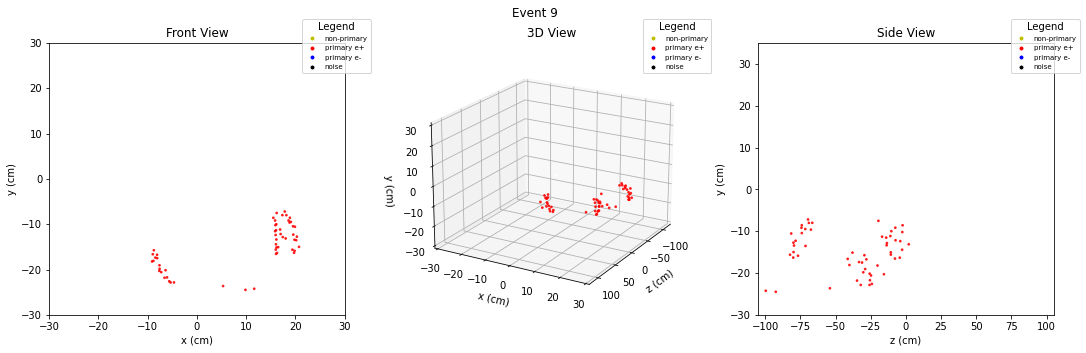

In [28]:
# Only prediction is plotted

atk.EventSelector(testpred, 9).plot("front 3D side")

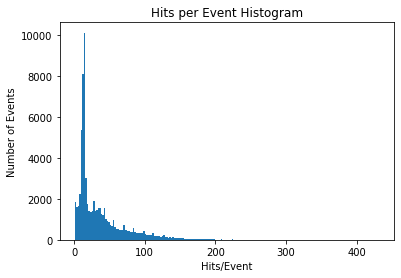

In [29]:
atk.draw_histogram(trig_df,200,"hits per event")

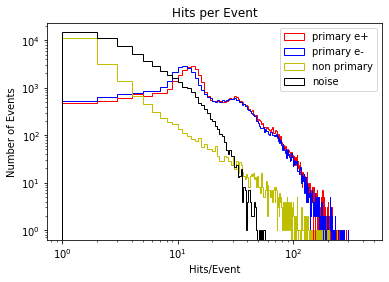

In [30]:
atk.draw_histogram(trig_df,200,"reconstructed hits per event")

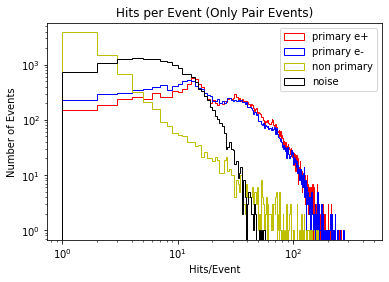

In [31]:
atk.draw_histogram(trig_df,200,"reconstructed hits per event (pair)")

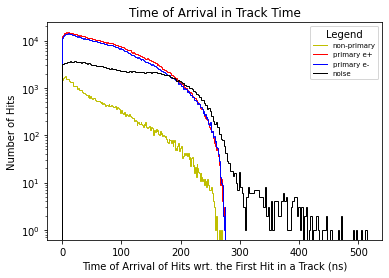

In [32]:
atk.draw_histogram(trig_df,200,"time of arrival - track time")

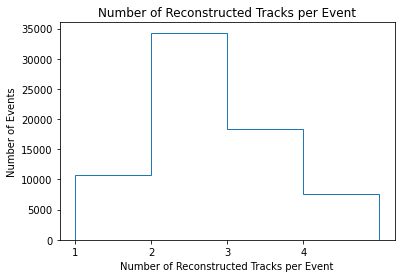

In [33]:
atk.draw_histogram(trig_df,200,"reconstructed tracks per event")

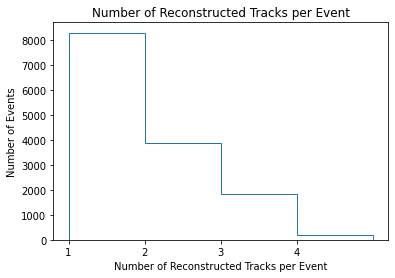

In [34]:
# Prediction is different from the true histogram.

atk.draw_histogram(testpred,200,"reconstructed tracks per event")

In [35]:
# Displaying what fraction of tracks are predicted correctly.

stats = atk.get_stats(test,pred)
stats

,iEvent,track,correct_hits,true_hits,norm_correct_hits
0,0,1,11,11,1.00000
1,1,1,11,21,0.52381
3,1,3,1,2,0.50000
4,2,1,13,13,1.00000
5,2,2,76,76,1.00000
...,...,...,...,...,...
34179,14190,1,3,3,1.00000
34180,14190,2,13,13,1.00000
34181,14190,3,1,2,0.50000
34182,14191,1,13,13,1.00000


In [36]:
# A table of comparison between the truth and the prediction

comparison_df = atk.compare_testpred(test,pred)
comparison_df

,iEvent,iHit,x,y,z,track,track_predicted
0,0,0,-20.7778,10.53850,24.3877,1,1
1,0,1,-18.0667,17.54850,72.9478,1,1
2,0,2,-19.9314,9.08452,28.4150,1,1
3,0,3,-19.6259,9.72355,28.3490,1,1
4,0,4,-19.3891,5.91772,11.8168,1,1
...,...,...,...,...,...,...,...
6130939,14191,427,0.0000,0.00000,0.0000,4,4
6130940,14191,428,0.0000,0.00000,0.0000,4,4
6130941,14191,429,0.0000,0.00000,0.0000,4,4
6130942,14191,430,0.0000,0.00000,0.0000,4,4


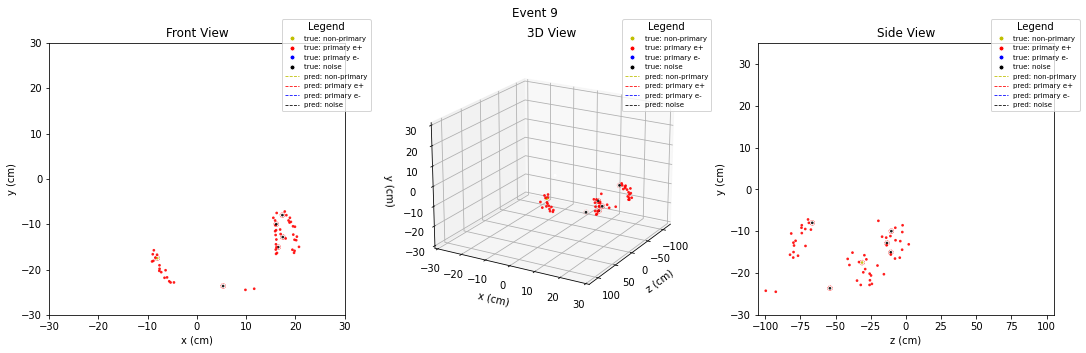

In [37]:
# Same event diplay, but both predictions and the true labels are visible

# plt.style.use("default")
atk.EventSelector(comparison_df, ind=9).plot("front 3D side")

In [38]:
# See the prediction contents

atk.get_event_contents(pred)

,e+,e-,sec,noise,tot
iEvent,,,,,
0,11.0,0.0,0.0,0.0,11.0
1,11.0,11.0,0.0,1.0,23.0
2,14.0,83.0,0.0,1.0,98.0
3,0.0,3.0,0.0,0.0,3.0
4,14.0,0.0,0.0,1.0,15.0
...,...,...,...,...,...
14187,0.0,23.0,0.0,0.0,23.0
14188,8.0,0.0,0.0,0.0,8.0
14189,34.0,0.0,0.0,1.0,35.0


In [39]:
# See the true contents

atk.get_event_contents(test.y)

,e+,e-,sec,noise,tot
iEvent,,,,,
0,11.0,0.0,0.0,0.0,11.0
1,21.0,0.0,0.0,2.0,23.0
2,13.0,76.0,0.0,9.0,98.0
3,0.0,3.0,0.0,0.0,3.0
4,12.0,0.0,0.0,3.0,15.0
...,...,...,...,...,...
14187,0.0,22.0,0.0,1.0,23.0
14188,7.0,0.0,0.0,1.0,8.0
14189,29.0,0.0,0.0,6.0,35.0


In [40]:
# Checking events where paired tracks are predicted
# at a level greater than 0.90 threshold

stats_tmp = stats.set_index(["iEvent", "track"])
stats_pos = stats_tmp.loc[:,1,:]
stats_ele = stats_tmp.loc[:,2,:]
stats_pair = pd.concat([stats_pos, stats_ele], axis=1, join="inner")
del stats_tmp
stats_pair[(stats_pair.norm_correct_hits > 0.90).all(axis=1)] 

,correct_hits,true_hits,norm_correct_hits,correct_hits,true_hits,norm_correct_hits
iEvent,,,,,,
2,13,13,1.0,76,76,1.000000
8,63,63,1.0,14,14,1.000000
11,38,38,1.0,9,9,1.000000
12,18,18,1.0,26,26,1.000000
15,38,38,1.0,34,34,1.000000
...,...,...,...,...,...,...
14159,1,1,1.0,45,45,1.000000
14170,1,1,1.0,43,43,1.000000
14176,16,16,1.0,10,11,0.909091


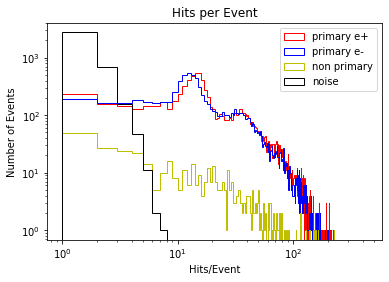

In [41]:
# Histogram related to the predicted labels

atk.draw_histogram(testpred,400,histo="reconstructed hits per event")

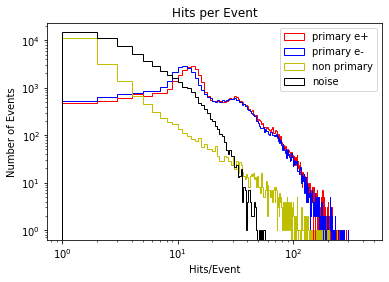

In [42]:
# Histogram related to the true labels

atk.draw_histogram(trig_df,400,histo="reconstructed hits per event")

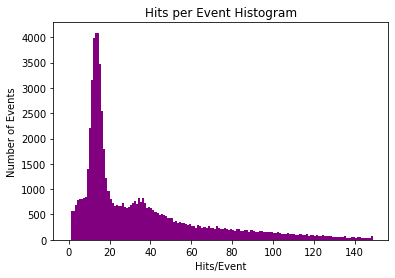

In [43]:
atk.draw_histogram(trig_df,np.arange(0,150,1),histo="hits per event", histtype="stepfilled", color="purple")

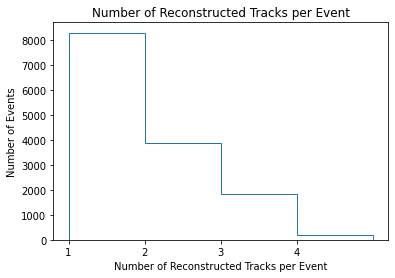

In [44]:
atk.draw_histogram(testpred,400,histo="reconstructed tracks per event")

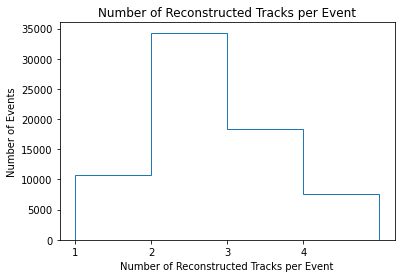

In [45]:
atk.draw_histogram(trig_df,400,histo="reconstructed tracks per event")

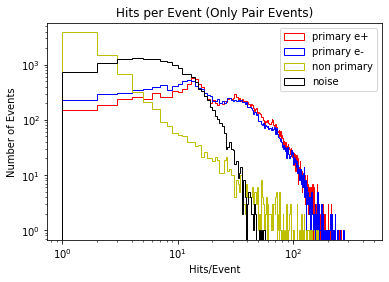

In [46]:
atk.draw_histogram(trig_df,400,histo="reconstructed hits per event (pair)")

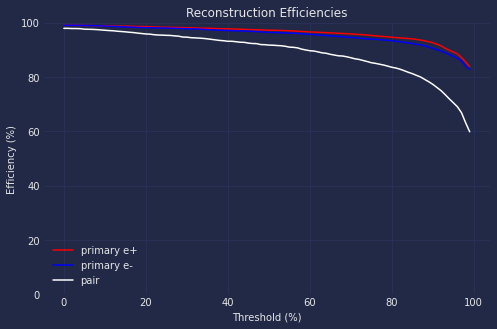

In [48]:
plt.style.use("seaborn-dark")
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'  # bluish dark grey
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  # very light grey
# plt.grid(color='#2A3459')  # bluish dark grey, but slightly lighter than background

lst = 100* np.asarray([atk.compute_efficiencies(stats, acceptance=6, threshold=i/100) for i in range(0, 100)])
plt.figure(figsize=(8,5))
plt.plot(lst[:,0], "r", label="primary e+")
plt.plot(lst[:,1], "b", label="primary e-")
plt.plot(lst[:,2], "w", label="pair")
plt.xlabel("Threshold (%)")
plt.ylabel("Efficiency (%)")
plt.title("Reconstruction Efficiencies")
plt.ylim(0,100)
plt.grid(which="minor", linestyle="-", color='#2A3459', alpha=0.2)
plt.grid(which="major", linestyle="-", color='#2A3459', alpha=1)
plt.legend()
plt.savefig("plots/rec_eff_acc.png", dpi=100)

In [50]:
atk.compute_efficiencies(stats, acceptance=6, threshold=0.90)

[0.9254495504495505, 0.9049967553536664, 0.7724434035909445]

In [51]:
_[0] * _[1]

0.8375288404003524

In [ ]:
# %%time
# ids = trig_df["iEvent"].unique()
# np.random.shuffle(ids)
# trig_df.set_index("iEvent").loc[ids].reset_index()